<a href="https://colab.research.google.com/github/MitaliThorat1316/Twitter-Sentiment-Analysis/blob/main/ML_twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing dependencies**

In [ ]:
# utilities
import os
import re
import numpy as np
import pandas as pd

# plotting
#!pip install wordcloud
#!pip install --upgrade wordcloud
#!pip install --upgrade pillow
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')  # optional, provides additional WordNet information

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


**Load dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',
                    encoding='ISO-8859-1',
                    names = ['sentiment','ids','date', 'flag', 'user', 'tweet'])

**Dataset Analysis**

In [ ]:
df

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   tweet      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.sentiment.value_counts()

,count
sentiment,
0,800000
4,800000


In [ ]:
df.shape

(1600000, 6)

In [ ]:
#find the maximum length
max_len = max([len(sent) for sent in df.tweet])
print('Max length: ', max_len)

Max length:  374


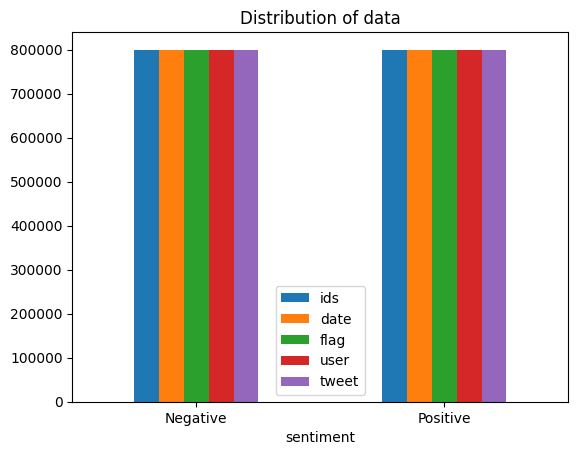

In [ ]:
# Plotting the distribution for dataset.
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=True)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
tweet, sentiment = list(df['tweet']), list(df['sentiment'])

<Axes: xlabel='sentiment', ylabel='count'>

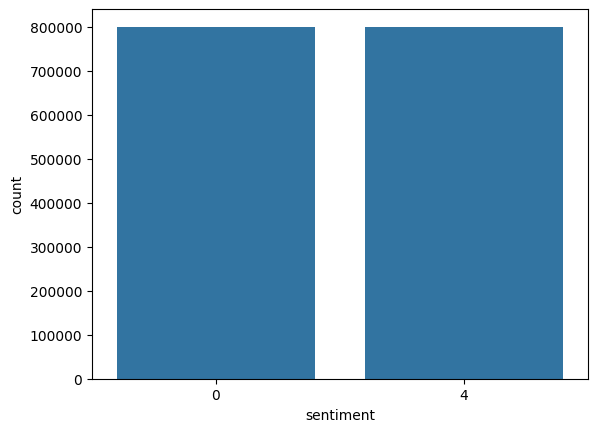

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

In [ ]:
df.loc[:, 'sentiment'] = df['sentiment'].replace(4, 1)

In [ ]:
df

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


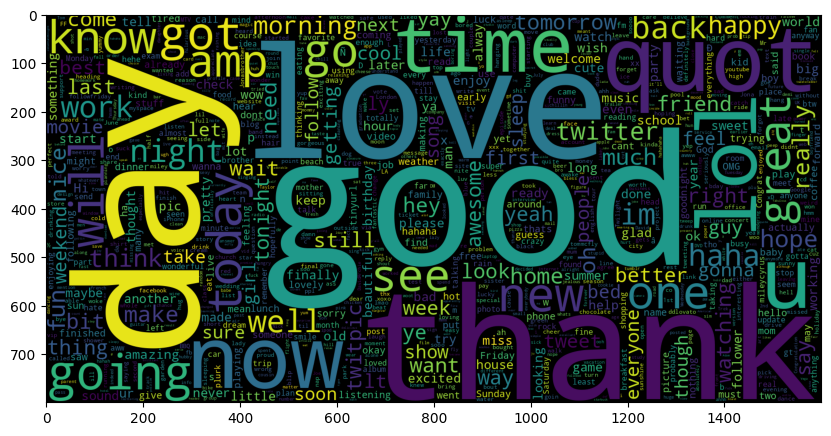

In [ ]:
data_pos = df['tweet'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (10,10))
plt.imshow(wc)

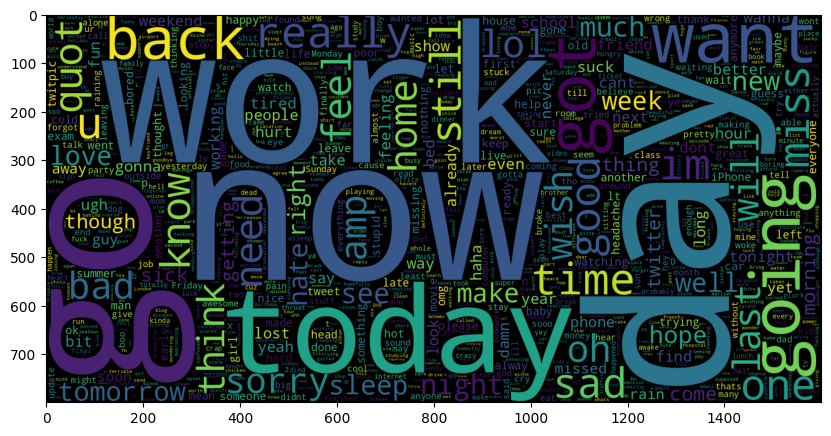

In [ ]:
data_neg = df['tweet'][:800000]
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

**Dataset Cleaning**

In [ ]:
df['tweet']=df['tweet'].str.lower()
df['tweet'].head()

,tweet
0,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,is upset that he can't update his facebook by ...
2,@kenichan i dived many times for the ball. man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['tweet'] = df['tweet'].apply(lambda text: cleaning_stopwords(text))
df['tweet'].head()

,tweet
0,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,upset can't update facebook texting it... migh...
2,@kenichan dived many times ball. managed save ...
3,whole body feels itchy like fire
4,"@nationwideclass no, it's not behaving all. i'..."


In [ ]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['tweet'] = df['tweet'].apply(lambda x: cleaning_URLs(x))
df['tweet'].head()

,tweet
0,@switchfoot s bummer. shoulda got david carr ...
1,upset can't update facebook texting it... migh...
2,@kenichan dived many times ball. managed save ...
3,whole body feels itchy like fire
4,"@nationwideclass no, it's not behaving all. i'..."


In [ ]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['tweet']= df['tweet'].apply(lambda x: cleaning_punctuations(x))
df['tweet'].head()

,tweet
0,switchfoot s bummer shoulda got david carr th...
1,upset cant update facebook texting it might cr...
2,kenichan dived many times ball managed save 50...
3,whole body feels itchy like fire
4,nationwideclass no its not behaving all im mad...


In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['tweet'] = df['tweet'].apply(lambda x: cleaning_repeating_char(x))
df['tweet'].head()

,tweet
0,switchfoot s bummer shoulda got david carr th...
1,upset cant update facebook texting it might cr...
2,kenichan dived many times ball managed save 50...
3,whole body feels itchy like fire
4,nationwideclass no its not behaving all im mad...


In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['tweet'] = df['tweet'].apply(lambda x: cleaning_numbers(x))
df['tweet']

,tweet
0,switchfoot s bummer shoulda got david carr th...
1,upset cant update facebook texting it might cr...
2,kenichan dived many times ball managed save r...
3,whole body feels itchy like fire
4,nationwideclass no its not behaving all im mad...
...,...
1599995,woke up no school best feeling ever
1599996,thewdbcom cool hear old walt interviews â«
1599997,ready mojo makeover ask details
1599998,happy th birthday boo alll time tupac amaru sh...


In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['tweet'] = df['tweet'].astype(str)
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)
df['tweet'].head()

,tweet
0,"[switchfoot, s, bummer, shoulda, got, david, c..."
1,"[upset, cant, update, facebook, texting, it, m..."
2,"[kenichan, dived, many, times, ball, managed, ..."
3,"[whole, body, feels, itchy, like, fire]"
4,"[nationwideclass, no, its, not, behaving, all,..."


In [ ]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text
df['tweet'] = df['tweet'].apply(lambda x: lemmatizer_on_text(x))
df['tweet'].head()

,tweet
0,"[switchfoot, s, bummer, shoulda, got, david, c..."
1,"[upset, cant, update, facebook, texting, it, m..."
2,"[kenichan, dived, many, time, ball, managed, s..."
3,"[whole, body, feel, itchy, like, fire]"
4,"[nationwideclass, no, it, not, behaving, all, ..."


**Splitting data into training and testing**

In [ ]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(df.tweet,df.sentiment,test_size = 0.2, stratify=df.sentiment, random_state =42)

**Transforming the Dataset Using TF-IDF Vectorizer**

In [ ]:
X_train_list = X_train.tolist()
# Ensure all elements are strings
X_train_list = [str(x) for x in X_train_list]

X_test_list = X_test.tolist()
# Ensure all elements are strings
X_test_list = [str(x) for x in X_test_list]

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
X_train_vect = vectoriser.fit_transform(X_train_list)
X_test_vect  = vectoriser.transform(X_test_list)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


**Function for Model Evaluation**

In [ ]:
def model_Evaluate(model):

    # Fit the model and Predict values for Test dataset
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

**Model Building**

              precision    recall  f1-score   support

           0       0.81      0.77      0.79    160000
           1       0.78      0.81      0.80    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



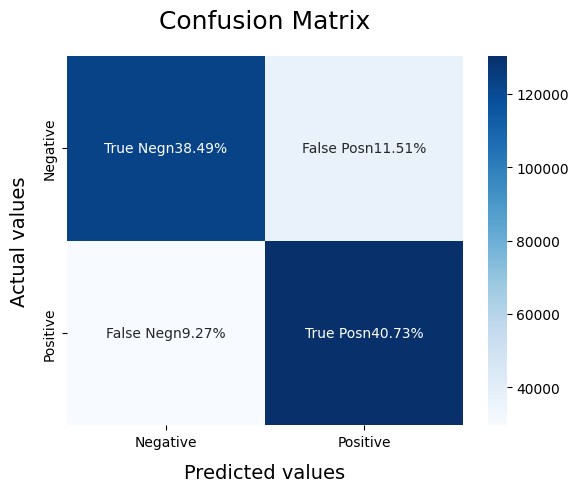

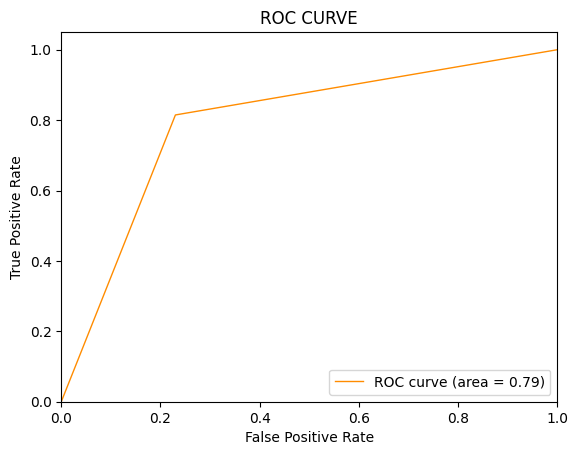

In [ ]:
BNBmodel = BernoulliNB()
model_Evaluate(BNBmodel)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.79      0.80    160000
           1       0.79      0.81      0.80    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



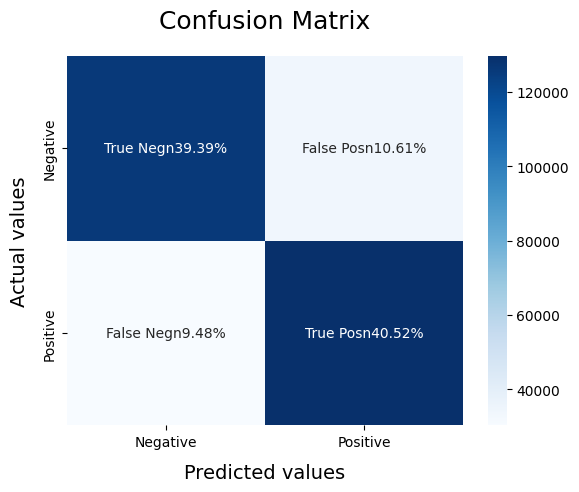

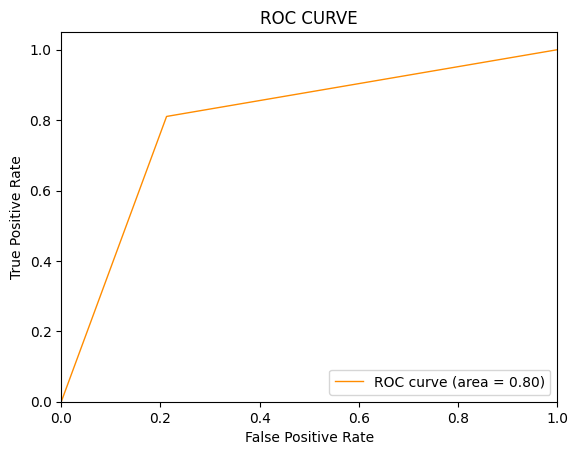

In [ ]:
SVCmodel = LinearSVC()
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81    160000
           1       0.80      0.82      0.81    160000

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



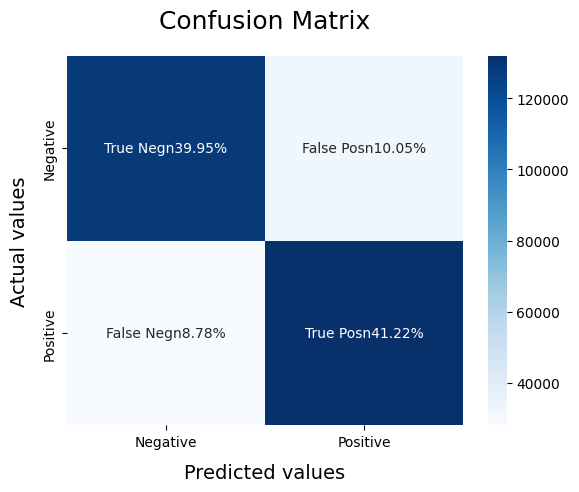

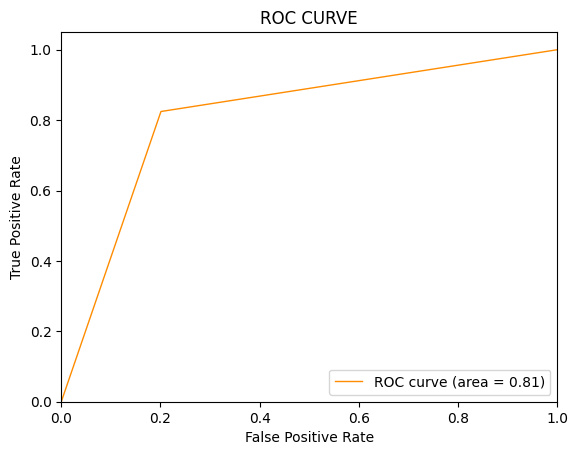

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
model_Evaluate(LRmodel)